# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Juan Bernardo Orozco Quirarte

**Professor**: Pablo Camarillo Ramirez

# Objective 
To build a data pipeline in Python using Apache Spark for data consumption, transformation, and persistence, with the objective of addressing a practical problem. 


# Introduction
### Breve descripción del problema: optimizar ocupación de gimnasios para reducir congestión en horarios punta, mejorar experiencia de usuario y planear recursos.

### Fuentes de decisión: usar checkins de usuarios y uso de equipo para:
- detectar horas pico
- calcular ocupación por zona/equipo
- proponer ventanas con baja ocupación

# Dataset 
### Modelo de datos: relacional (tablas: gyms, users, checkins)
- gyms(gym_id, name, city)
- users(user_id, username, age, membership_type)
- checkins(checkin_id, gym_id, user_id, timestamp, equipment, duration_min)

### CSVs Generados con Faker y disponibles en la carpeta lib/bernardoorozco/project junto con el .py que genera datos con faker "faker_project_generator.py"

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Final Project Batch Processing") \
    .master("spark://spark-master:7077") \
    .config("spark.jars", "jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

25/10/25 08:24:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from bernardoorozco.spark_utils import SparkUtils
base_path = "/opt/spark/work-dir/lib/bernardoorozco/project"

gyms_schema= SparkUtils.generate_schema([
    ("gym_id", "string"),
    ("name", "string"),
    ("city", "string")
])

users_schema= SparkUtils.generate_schema([
    ("user_id", "string"),
    ("username", "string"),
    ("age", "int"),
    ("membership_type", "string")
])

checkins_schema= SparkUtils.generate_schema([
    ("checkin_id", "string"),
    ("gym_id", "string"),
    ("user_id", "string"),
    ("timestamp", "timestamp"),  
    ("equipment", "string"),
    ("duration_min", "int")
])

gyms_df = spark.read.schema(gyms_schema).option("header", True).csv(f"{base_path}/csvs/gyms.csv")
users_df = spark.read.schema(users_schema).option("header", True).csv(f"{base_path}/csvs/users.csv")
checkins_df = spark.read.schema(checkins_schema).option("header", True).csv(f"{base_path}/csvs/checkins.csv")

# Transformations and Actions

In [3]:
from pyspark.sql.functions import hour, dayofweek, col,count, avg

checkins_clean = (
    checkins_df
    .filter(col("timestamp").isNotNull())               # eliminamos si no tienen timestamp (todos nuestros chekins tienen, pero enel hipotetico caso)
    .filter(col("duration_min") > 0)                    # eliminar duraciones no valida en caso de que existan (cosa que no pasa porque nuestro generador solo genera duraciones de entre 15 y 120 mins)
)

## Creamos una columna con la hora y dia de la semana para futuros analisis de horas/dias pico y congestiones

In [4]:
checkins_timedata = (
    checkins_clean
    .withColumn("hour", hour(col("timestamp")))
    .withColumn("dayofweek", dayofweek(col("timestamp")))
)

checkins_timedata = checkins_timedata.dropDuplicates(["checkin_id"])

# Join de checkins con users y gyms en el respectivo ID de cada uno

In [5]:
checkins_full=checkins_timedata.join(gyms_df, on="gym_id", how="left").join(users_df, on="user_id", how="left")

In [6]:
occupancy_by_hour = (
    checkins_full
    .groupBy("gym_id", "name", "city", "hour", "dayofweek" ,"equipment")
    .agg(
        count("*").alias("checkin_count"),
        avg("duration_min").alias("avg_duration_min")
    )
)

In [7]:
top_equipment = (occupancy_by_hour.orderBy(col("checkin_count").desc()))

# Persistence Data

## Install PostgreSQL with Docker


    docker run -d --name postgres-iteso --network spark_default -e POSTGRES_PASSWORD=Admin@1234 postgres

In [8]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "top_equipment_use"

top_equipment.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame escrito en PosgreSQL DB !")

DataFrame escrito en PosgreSQL DB !


# DAG

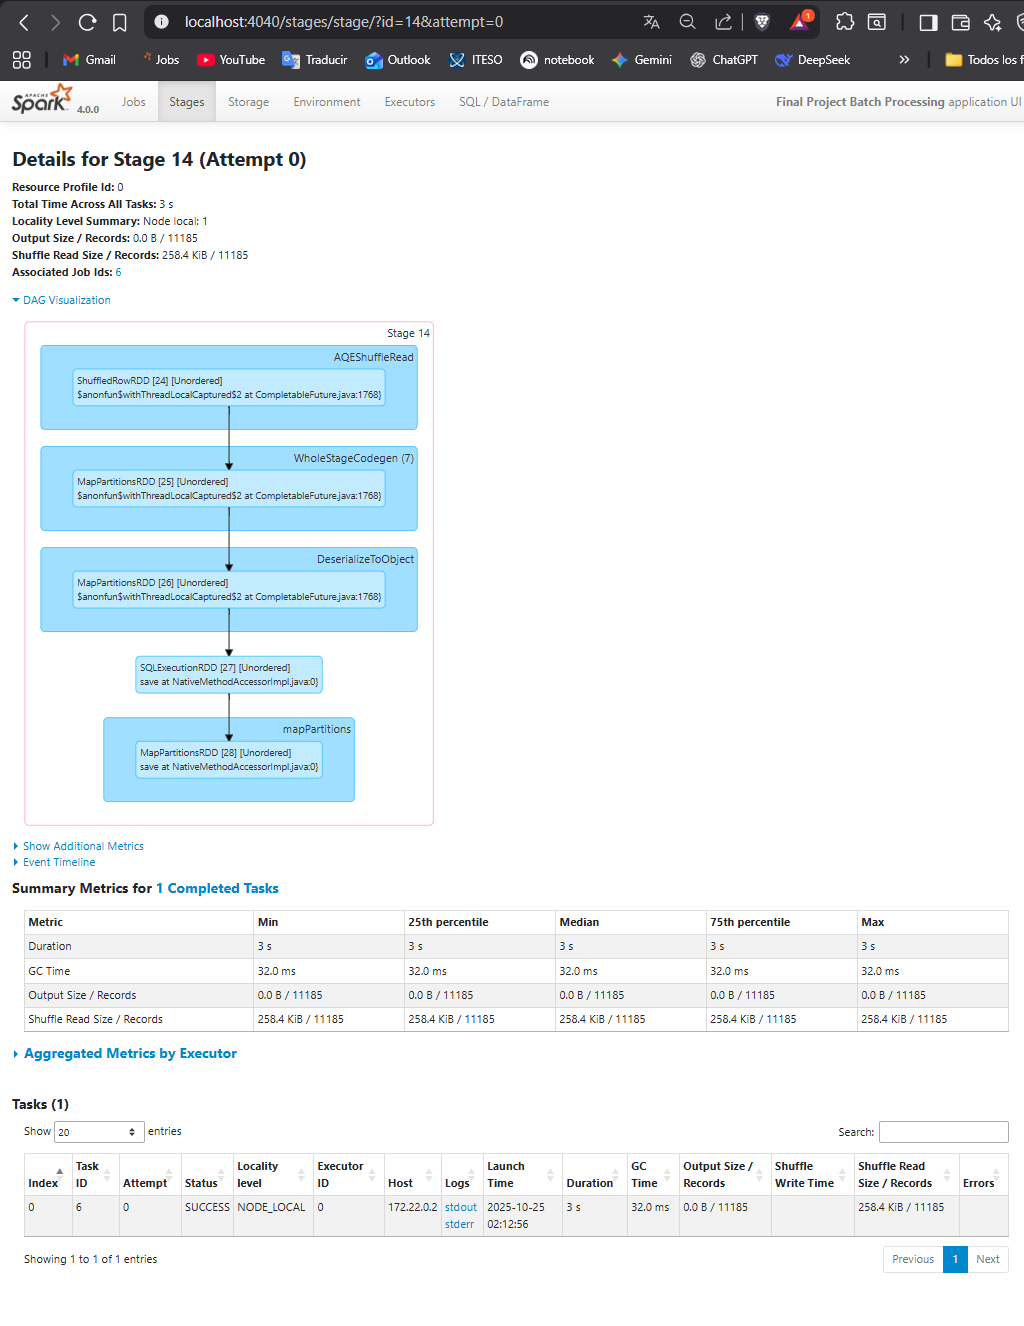

# Prueba de los datos en el contenedor de Postgres SQL 

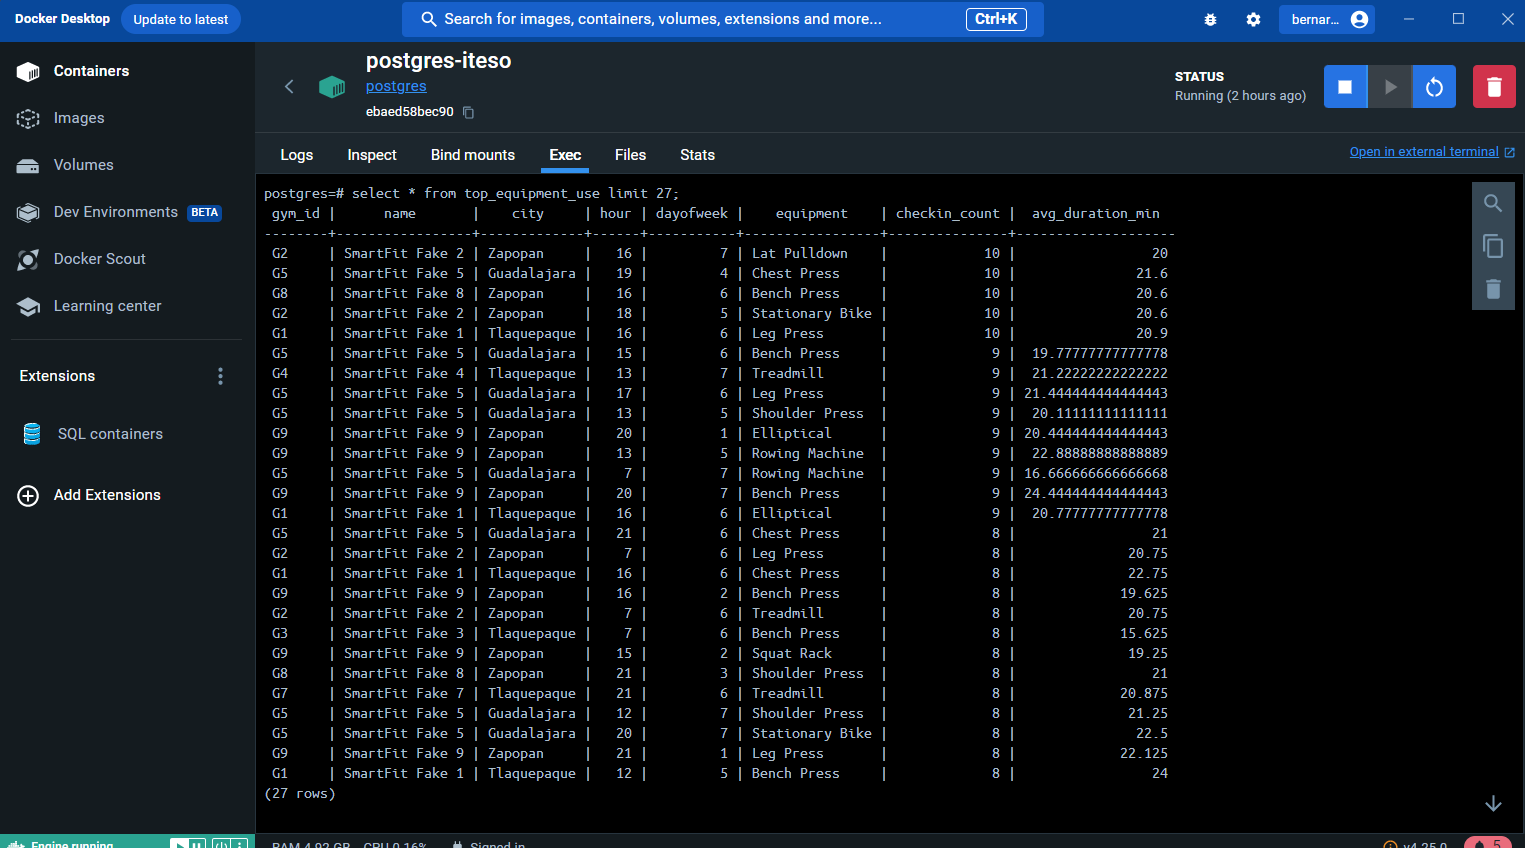

In [9]:
sc.stop()